# Stand-alone TensorBoard Projector Demonstration
Based on TensorFlow's publicly available "demo" code.
## Sources

github repositories:
- https://github.com/harveyslash/TSNE-UMAP-Embedding-Visualisation.git
- https://github.com/tensorflow/embedding-projector-standalone

Discussions:
- https://github.com/tensorflow/tensorflow/issues/7562
- https://stackoverflow.com/questions/41643365/standalone-tensorflow-projector

## Setup

In order to run a local projector, the library should contain the following files:
- index.html
- folder: oss_data
  - oss_demo_projector_config.json (must)
  - tensors.bytes (must)
  - labels.tsv (optional)
  - sprites.png (optional)

Note: the json file points to the other files' location, so their location is flexible.

## Preparing
Train a NN for MNIST dataset


In [168]:
import json
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm

In [169]:
os.makedirs('./data', exist_ok=True)
mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

print(mnist_train)
print(mnist_test)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [170]:
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [171]:
x, y = next(iter(test_dataloader))
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Model to have an 'embedding' method

In [172]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=28*28, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=16, bias=True),
            nn.ReLU(),
        )
        self.head = nn.Linear(in_features=16, out_features=10, bias=True)
    
    def forward(self, x):
        return self.head(self.embedding(x))
    
    def embedding(self, x):
        return self.encoder(x)


In [173]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleNet().to(device)

In [175]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optim = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=.9)
model.train()

EPOCHS = 2
losses = []
accuracies = []
total_samples = 0

for epoch in range(EPOCHS):
    batch_loss = 0
    correct = 0
    total_samples = 0

    for X, y in tqdm(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        logits = model(X.to(device))
        loss = loss_fn(logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        batch_loss += loss.item()
        y_pred = logits.argmax(dim=1)
        correct += (y_pred == y).to(torch.float32).sum().item()
        total_samples += y.shape[0]

    batch_loss /= total_samples
    batch_acc = correct / total_samples
    losses.append(batch_loss)
    accuracies.append(batch_acc)
    print(f'epoch: {epoch+1}/{EPOCHS}: loss: {batch_loss:.4f}, accuracy: {batch_acc:.4f}')
    

100%|██████████| 938/938 [00:05<00:00, 173.69it/s]


epoch: 1/5: loss: 0.7232, accuracy: 0.7809


100%|██████████| 938/938 [00:05<00:00, 176.86it/s]


epoch: 2/5: loss: 0.2675, accuracy: 0.9220


100%|██████████| 938/938 [00:05<00:00, 176.39it/s]


epoch: 3/5: loss: 0.1907, accuracy: 0.9453


100%|██████████| 938/938 [00:05<00:00, 178.07it/s]


epoch: 4/5: loss: 0.1469, accuracy: 0.9573


100%|██████████| 938/938 [00:05<00:00, 177.50it/s]

epoch: 5/5: loss: 0.1191, accuracy: 0.9655


In [176]:
correct = 0
samples = 0
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X.to(device))
        y_pred = logits.argmax(dim=1)
        correct += (y_pred == y).to(torch.float32).sum().item()
        samples += y.shape[0]

acc = correct / samples
print('Test Accuaracy: ', acc)

Test Accuaracy:  0.9631


### Generate Projector Files

Code for generating image grid

In [105]:
def images_to_sprite(data):
    """
    Creates the sprite image along with any necessary padding
    Source : https://github.com/tensorflow/tensorflow/issues/6322
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[..., np.newaxis], (1, 1, 1, 3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) - min).transpose(3, 0, 1, 2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) / max).transpose(3, 0, 1, 2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
               (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                  constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose(
        (0, 2, 1, 3) + tuple(range(4, data.ndim + 1))
    )
    data = data.reshape(
        (n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data


Gather original data, labels and embeddings

In [164]:
metadata = []
test_data, test_labels = next(iter(test_dataloader))
train_data, train_labels = next(iter(train_dataloader))
# data shape: [64, 1, 28, 28]

# sprite generator expects "channel last"
test_images = test_data.numpy().transpose((0, 2, 3, 1)).squeeze()
train_images = train_data.numpy().transpose((0, 2, 3, 1)).squeeze()

# generate embeddings
with torch.no_grad():
    test_embeddings = model.embedding(test_data.to(device)).cpu().detach().numpy()
    train_embeddings = model.embedding(train_data.to(device)).cpu().detach().numpy()

# gather all samples together
images = np.vstack((test_images, train_images))
embeddings = np.vstack((test_embeddings, train_embeddings))
metadata.extend(['test\t' + str(label.item()) for label in test_labels])
metadata.extend(['train\t' + str(label.item()) for label in train_labels])

Save to file:

    - *.bytes file (embeddings)

    - *.tsv file (labels)

    - *.png file (images)

In [165]:
# create oss_data folder
os.makedirs('./oss_data/', exist_ok=True)
viz_name = 'MNIST'

# generate *.bytes file
embeddings.tofile(f'./oss_data/{viz_name}_embeddings.bytes')

# generate metadata file
txt = '\n'.join(metadata)
with open(f'./oss_data/{viz_name}_labels.tsv', 'w') as f:
    f.write('set\tclass\n')
    f.write(txt)
f.close()

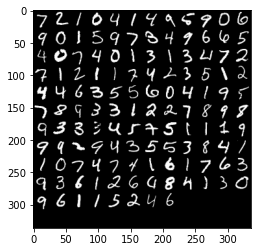

In [166]:
image_h, image_w = tuple(images.shape[1:])
sprite = Image.fromarray(images_to_sprite(images))
sprite.save(f'./oss_data/{viz_name}_sprite.png')
plt.imshow(sprite)

### Configuration file
A structured format

Includes paths to the data/labels/sprite files

In [177]:
# generate config file
oss_json = {'embeddings': [{"tensorName": viz_name,
                            "tensorShape": list(embeddings.shape),
                            "tensorPath": f"./oss_data/{viz_name}_embeddings.bytes",
                            "metadataPath": f"./oss_data/{viz_name}_labels.tsv",
                            "sprite": {"imagePath": f"./oss_data/{viz_name}_sprite.png",
                                            "singleImageDim": [image_h, image_w]}
                            }],
            "modelCheckpointPath": "MNIST local model",
            }
with open('oss_data/oss_demo_projector_config.json', 'w') as f:
    json.dump(oss_json, f, ensure_ascii=False, indent=4)



In the Terminal from root folder:

`python3 -m http.server`